In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List

In [134]:
class Activation:
  def __init__(self, types: str = 'sigmoid') -> None:
    if types == 'sigmoid':
      self.func = self.sigmoid
      self.dfunc = self.d_sigmoid
    elif types == 'tanh':
      self.func = self.tanh
      self.dfunc = self.d_tanh
    elif types == 'relu':
      self.func = self.relu
      self.dfunc = self.d_relu
    elif types == 'linear':
      self.func = self.linear
      self.dfunc = self.d_linear
    else:
      raise ValueError(f'Activation function {types} not found')

  def sigmoid(self, x):
    return 1 / (1 + np.exp(-x))

  def d_sigmoid(self, x):
    return x * (1 - x)

  def tanh(self, x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

  def d_tanh(self, x):
    return 1 - np.power(x, 2)

  def relu(self, x):
    return np.maximum(0, x)

  def d_relu(self, x):
    return np.where(x > 0, 1, 0)

  def linear(self, x):
    return x

  def d_linear(self, x):
    return np.ones_like(x)

In [110]:
class Neuron:
  def __init__( self,
                n_weights: int,
                activation: str = 'sigmoid',
                bias=1 ):
    self.weights = np.random.rand(n_weights)
    self.bias = bias
    self.output = 0.0
    self.inputs = []
    self.delta = 0.0
    self.n_weights = n_weights
    self.activation = Activation(activation)

  def calculate_output(self, inputs):
    if len(inputs) != self.n_weights:
      raise ValueError(f'Expected {self.n_weights} inputs, but got {len(inputs)}')

    self.inputs = np.array(inputs)
    weighted_sum = np.dot(self.inputs, self.weights) + self.bias
    self.output = self.activation.func(weighted_sum)

    return self.output

  def calculate_delta(self, error=None):
    self.delta = error * self.activation.dfunc(self.output)

  def update_weights(self, learning_rate: float) -> None:
    self.weights -= learning_rate * self.delta * self.inputs
    self.bias -= learning_rate * self.delta
    self.calculate_output(self.inputs)

  def __str__(self) -> str:
    return f'--- weights = {self.weights}, bias = {self.bias}'

In [111]:
class NeuralLayer:
  __counter = 0

  def __init__( self,
                n_inputs: int,
                n_neuron: int,
                activation: str ) -> None:
    self.neurons = [Neuron(n_inputs, activation) for _ in range(n_neuron)]
    self.__counter = NeuralLayer.__counter + 1

  def deltas(self):
    return np.array([neuron.delta for neuron in self.neurons])

  def forward(self, inputs) -> List[float]:
    outputs = np.array([neuron.calculate_output(inputs) for neuron in self.neurons])
    return outputs

  def update_weight(self, learnings_rate: float) -> None:
    for neuron in self.neurons:
      neuron.update_weights(learnings_rate)

  def __str__(self) -> str:
    return f'-- Layer {self.__counter}  # of neurons = {len(self.neurons)}'

In [128]:
class NeuralNetwork:
  def __init__( self,
                learning_rate: float = 0.01,
                error: str = 'mse',
                debug: bool =True ) -> None:
    self.error = error
    self.learning_rate = learning_rate
    self.debug = debug
    self.layers = []
    self.error_per_epoch = []

  def add_layer( self,
                 n_inputs: int,
                 n_neurons:int,
                 activation: str = 'sigmoid' ) -> None:
    layer = NeuralLayer(n_inputs, n_neurons, activation)
    self.layers.append(layer)

  def forward(self, inputs) -> List[float]:
    for idx, layer in enumerate(self.layers):
      inputs = layer.forward(inputs)

      if self.debug:
        print(f'Layer {idx + 1}: {inputs}')

    return inputs

  def backpropagation(self, targets) -> None:
    if len(targets) != len(self.layers[-1].neurons):
      raise ValueError(f'Expected {len(self.layers[-1].neurons)} targets, but got {len(targets)}')

    output_layer = self.layers[-1]
    for i, neuron in enumerate(output_layer.neurons):
      error = -(targets[i] - neuron.output)
      neuron.calculate_delta(error)

    if self.debug:
      print('Output layer delta:', self.layers[-1].deltas)

    for l in reversed(range(len(self.layers) - 1)):
      curr_layer = self.layers[l]
      next_layer = self.layers[l + 1]

      for i, neuron in enumerate(curr_layer.neurons):
        error = np.dot([n.weights[i] for n in next_layer.neurons], next_layer.deltas())
        neuron.calculate_delta(error)

      if self.debug:
        print(f'Hidden layer {l} delta:', curr_layer.deltas)

  def update_weight(self) -> None:
    for layer in self.layers:
      layer.update_weight(self.learning_rate)

  def calculate_single_error(self, targets, outputs) -> float:
    # error = 0

    # for i in range(len(targets)):
    #   if self.error == 'mse':
    #     error += (targets[i] - outputs[i]) ** 2
    #   elif self.error == 'mae':
    #     error += abs(targets[i] - outputs[i])

    # return error
    if self.error == 'mse':
      return np.mean(np.square(targets - outputs))
    elif self.error == 'mae':
      return np.mean(np.abs(targets - outputs))

  def calculate_total_error(self, data) -> float:
    total_error = 0.0

    for inputs, targets in data:
      outputs = self.forward(inputs)
      total_error += self.calculate_single_error(targets, outputs)

    return total_error / len(data)

  def train( self,
             data,
             epochs: int = 100,
             batch_size: int | None = None,
             print_error: bool = True ) -> None:
    print('\n> Training...')

    batch_size = batch_size if batch_size else len(data)
    np.random.shuffle(data)

    for epoch in range(epochs):
      for batch_start in range (0, len(data), batch_size):
        batch = data[batch_start:batch_start + batch_size]

        for inputs, targets in batch:
          self.forward(inputs)
          self.backpropagation(targets)

        self.update_weight()

      total_error = self.calculate_total_error(data)
      self.error_per_epoch.append(total_error)

      if print_error:
        print(f'Epoch {epoch + 1}/{epochs} - Error: {total_error}')

    print('\n> Training done!')

  def predict(self, data):
    print('\n> Predicting...')

    for idx, (inputs, targets) in enumerate(data):
      if self.debug:
        print(f'\n>>> data #{idx + 1}')

      outputs = self.forward(inputs)
      print(f'[#{idx}] -> {outputs} (target: {targets})')

    total_error = self.calculate_total_error(data)

    print(f'\n> Prediction done! Error: {total_error}')

  def __str__(self) -> str:
    input_neurons = self.layers[0].neurons[0].n_weights if self.layers else 0
    input_info = f'Input Layer: {input_neurons} features'

    layer_info = '\n'.join([f'Layer {idx + 1}: {len(layer.neurons)} neurons' for idx, layer in enumerate(self.layers)])

    return f'Neural Network\n{input_info}\n{layer_info}'

In [150]:
df = pd.read_csv('Housing.csv')
df.head(5)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [151]:
df.dtypes

price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad            object
guestroom           object
basement            object
hotwaterheating     object
airconditioning     object
parking              int64
prefarea            object
furnishingstatus    object
dtype: object

In [152]:
def replaceCategorial(df, columns, mapping):

  for column in columns:
    df[column] = df[column].map(mapping)

replaceCategorial(df, ['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea'], { 'yes': 1, 'no': 0 })
replaceCategorial(df, ['furnishingstatus'], {'furnished': 0, 'semi-furnished': 1, 'unfurnished': 2})

df.head(20)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0
5,10850000,7500,3,3,1,1,0,1,0,1,2,1,1
6,10150000,8580,4,3,4,1,0,0,0,1,2,1,1
7,10150000,16200,5,3,2,1,0,0,0,0,0,0,2
8,9870000,8100,4,1,2,1,1,1,0,1,2,1,0
9,9800000,5750,3,2,4,1,1,0,0,1,1,1,2


In [153]:
# perform standard scaler from scratch
def standard_scaler(X):
  return (X - X.mean(axis=0)) / X.std(axis=0)

def min_max_scaler(X):
  return (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

# df = standard_scaler(df.values)
df = min_max_scaler(df.values)

In [154]:
def train_test_split(df, test_size=0.25):

  np.random.shuffle(df)
  split = int(len(df) * (1 - test_size))

  return df[:split], df[split:]

train, test = train_test_split(df, test_size=0.2)
X_train, y_train = train[:, 1:], train[:, 0]
X_test, y_test = test[:, 1:], test[:, 0]

In [156]:
# train_dataset = [
#             [(1, 0), [1]],
#             [(0, 0), [0]],
#             [(0, 1), [1]],
#             [(1, 1), [0]]
#             ]

train_dataset = [[(X_train[i]), [y_train[i]]] for i in range(len(X_train))]

nn = NeuralNetwork(learning_rate=0.01, debug=False)
nn.add_layer(n_inputs=12, n_neurons=64, activation='sigmoid')
nn.add_layer(n_inputs=64, n_neurons=32, activation='relu')
nn.add_layer(n_inputs=32, n_neurons=16, activation='sigmoid')
nn.add_layer(n_inputs=16, n_neurons=1, activation='linear')

print(nn)

# nn = NeuralNetwork(learning_rate=0.1, debug=False)
# nn.add_layer(n_inputs=2, n_neurons=3, activation='sigmoid')
# nn.add_layer(n_inputs=3, n_neurons=1, activation='sigmoid')

nn.train(data=train_dataset, epochs=100, print_error=True)

Neural Network
Input Layer: 12 features
Layer 1: 64 neurons
Layer 2: 32 neurons
Layer 3: 16 neurons
Layer 4: 1 neurons

> Training...
Epoch 1/100 - Error: 55.011232686932935
Epoch 2/100 - Error: 37.750891805919984
Epoch 3/100 - Error: 25.969594809353744
Epoch 4/100 - Error: 17.762048113595363
Epoch 5/100 - Error: 11.98854051071155
Epoch 6/100 - Error: 8.194915310621353
Epoch 7/100 - Error: 5.613455084751638
Epoch 8/100 - Error: 3.817878979516978
Epoch 9/100 - Error: 2.674180783985385
Epoch 10/100 - Error: 1.8604884682589173
Epoch 11/100 - Error: 1.2695301438215223
Epoch 12/100 - Error: 0.8688032068794471
Epoch 13/100 - Error: 0.5554300842444128
Epoch 14/100 - Error: 0.3503442551174099
Epoch 15/100 - Error: 0.23089687504797712
Epoch 16/100 - Error: 0.15502060735860967
Epoch 17/100 - Error: 0.11670652785310211
Epoch 18/100 - Error: 0.07920003812087671
Epoch 19/100 - Error: 0.060191661202500225
Epoch 20/100 - Error: 0.05429134143808053
Epoch 21/100 - Error: 0.0389928690164162
Epoch 22/100

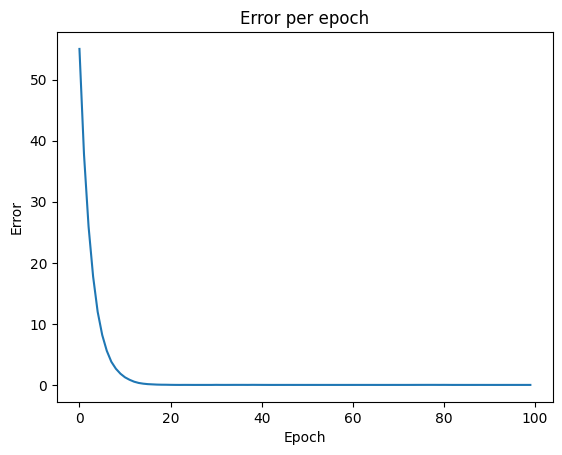

In [157]:
plt.plot(nn.error_per_epoch)
plt.title('Error per epoch')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

In [158]:
# test_dataset = [
#     [[1, 0], [1]],
#     [[0, 0], [0]]
# ]

test_dataset = [[(X_test[i]), [y_test[i]]] for i in range(len(X_test))]

nn.predict(test_dataset)


> Predicting...
[#0] -> [0.23363066] (target: [0.36363636363636365])
[#1] -> [0.23363066] (target: [0.05454545454545454])
[#2] -> [0.23363066] (target: [0.16363636363636364])
[#3] -> [0.23363066] (target: [0.4121212121212121])
[#4] -> [0.23363066] (target: [0.13636363636363635])
[#5] -> [0.23363066] (target: [0.3333333333333333])
[#6] -> [0.23363066] (target: [0.21818181818181817])
[#7] -> [0.23363066] (target: [0.12121212121212122])
[#8] -> [0.23363066] (target: [0.15151515151515152])
[#9] -> [0.23363066] (target: [0.10303030303030303])
[#10] -> [0.23363066] (target: [0.2727272727272727])
[#11] -> [0.23363066] (target: [0.36363636363636365])
[#12] -> [0.23363066] (target: [0.09696969696969697])
[#13] -> [0.23363066] (target: [0.49393939393939396])
[#14] -> [0.23363066] (target: [0.10303030303030303])
[#15] -> [0.23363066] (target: [0.06060606060606061])
[#16] -> [0.23363066] (target: [0.18181818181818182])
[#17] -> [0.23363066] (target: [0.5])
[#18] -> [0.23363066] (target: [0.166666